# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

# Collaborative filtering

Lorsque vous avez plusieurs utilisateurs et plusieurs produits, vous voulez recommander les produits qui sont les plus susceptibles d'être utiles pour chaque utilisateur. Il existe de nombreuses variantes, par exemple recommander des films (comme sur Netflix), déterminer ce qu'il faut mettre en évidence pour un utilisateur sur une page d'accueil, décider quelles histoires montrer dans un flux de médias sociaux, etc. 

Il existe une solution générale à ce problème, appelée **filtrage collaboratif**, qui fonctionne de la manière suivante : examiner les produits que l'utilisateur actuel a utilisés ou appréciés, trouver d'autres utilisateurs qui ont utilisé ou apprécié des produits similaires, puis recommander les produits que ces autres utilisateurs ont utilisés ou appréciés.

Par exemple, sur Netflix, vous avez peut-être regardé beaucoup de films de science-fiction, pleins d'action, qui ont été réalisés dans les années 1970. Netflix ne connaît peut-être pas ces propriétés particulières des films que vous avez regardés, mais il peut constater que d'autres personnes qui ont regardé les mêmes films que vous ont également eu tendance à regarder d'autres films de science-fiction, pleins d'action, et réalisés dans les années 70. En d'autres termes, pour utiliser cette approche, nous n'avons pas nécessairement besoin de connaître quoi que ce soit sur ces films, seulement qui aime les regarder.

Il existe en fait une catégorie plus générale de problèmes que cette approche peut résoudre, et pas seulement des problèmes qui concernent les utilisateurs et les produits. Les éléments peuvent être des liens sur lesquels vous cliquez, des diagnostics sélectionnés pour les patients, etc.

L'idée fondamentale est celle des **caractéristiques latentes** (latent factors). Dans l'exemple de Netflix ci-dessus, nous sommes partis du principe que vous aimez les vieux films de science-fiction d'action. Mais vous n'avez jamais vraiment dit à Netflix que vous aimiez ce genre de films. Et Netflix n'a jamais eu besoin d'ajouter des colonnes à son tableau des films pour indiquer quels sont les films de ce type. Mais il doit y avoir un concept sous-jacent de science-fiction, d'action et d'âge du cinéma. Et ces concepts doivent être pertinents pour les décisions que prennent au moins certaines personnes en matière de visionnage de films.

## Un premier aperçu des données

In [1]:
from fastai2.collab import *
from fastai2.tabular.all import *

Nous allons utiliser un jeu de données appelé [MovieLens](https://grouplens.org/datasets/movielens/). Ce jeu de données contient des dizaines de millions de notes de films (c'est-à-dire une combinaison d'un identifiant de film, d'un identifiant d'utilisateur et d'une note numérique), même si nous n'utiliserons qu'un sous-ensemble de 100 000 d'entre eux pour notre exemple. 

In [2]:
path = untar_data(URLs.ML_100k)

In [10]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user','movie','rating','timestamp'])

In [11]:
ratings.head(10)

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [8]:
len(ratings)

100000

Exemple de représentation des "caractéristiques latentes" des films et des utilisateurs.

Si nous savions, pour chaque utilisateur, dans quelle mesure il aime chaque catégorie importante à laquelle un film peut appartenir, comme le genre, l'âge, les réalisateurs et acteurs préférés, etc. et si nous connaissions les mêmes informations sur chaque film, alors une façon simple de prédire la colonne "rating" serait de multiplier ces informations ensemble pour chaque film et de les additionner. 

Par exemple, en supposant que ces facteurs se situent entre -1 et un facteur positif, et que positif signifie une correspondance élevée et négatif une correspondance faible, et que les catégories sont la science-fiction, l'action et les vieux films, alors nous pourrions représenter le film The Last Skywalker comme :

In [12]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [13]:
user1 = np.array([0.9,0.8,-0.6])

In [14]:
(user1*last_skywalker).sum()

2.1420000000000003

In [15]:
casablanca = np.array([-0.99,-0.3,0.8])

In [16]:
(user1*casablanca).sum()

-1.611

Lorsque nous multiplions deux vecteurs ensemble et additionnons les résultats, on parle de produit scalaire (dot product). 

jargon : produit scalaire (dot product) : opération mathématique consistant à multiplier les éléments de deux vecteurs ensemble, puis à additionner le résultat.

## Apprendre les caractéristiques latentes

Il y a étonnamment peu de chemin entre la spécification de la structure d'un modèle, comme nous l'avons fait dans la dernière section, et l'apprentissage d'un modèle, puisque nous pouvons simplement utiliser notre approche de descente de gradient.

La première étape de cette approche consiste à initialiser de manière aléatoire certains paramètres. Ces paramètres seront un ensemble de caractéristiques latentes pour chaque utilisateur et chaque film. Nous devrons décider du nombre de paramètres à utiliser. Nous discuterons prochainement de la manière de sélectionner ces paramètres, mais à titre d'illustration, nous en utiliserons 5 pour l'instant. Chaque utilisateur aura 5 caractéristiques, et chaque film 5 caractéristiques : nous pouvons afficher ces valeurs initialisées de façon aléatoire juste à côté des utilisateurs et des films dans un tableau croisé.

La deuxième étape de cette approche consiste à calculer nos prévisions. Comme nous l'avons vu, nous pouvons le faire en prenant simplement le produit scalaire de chaque film avec chaque utilisateur. Si, par exemple, la première caractéristique latente d'un utilisateur eprésente combien il aime les films d'action, et la première caractéristique latente d'un filmreprésente si le film contient beaucoup d'action ou non, alors le produit de ces deux facteurs sera particulièrement élevé si l'utilisateur aime les films d'action et si le film contient beaucoup d'action ou si l'utilisateur n'aime pas les films d'action et si le film ne contient pas d'action. En revanche, si nous avons un décalage (un utilisateur aime les films d'action mais que le film n'en contient pas, ou l'utilisateur n'aime pas les films d'action et que le film en contient), le produit sera très faible.

La troisième étape consiste à calculer l'erreur de prédiction. Nous pouvons utiliser n'importe quelle fonction de coût ; c'est-à-dire choisir l'erreur quadratique moyenne (mean squared error) pour l'instant, car c'est une façon raisonnable de représenter la précision d'une prédiction.

C'est tout ce dont nous avons besoin. Une fois cette fonction en place, nous pouvons optimiser nos paramètres (c'est-à-dire les caractéristiques latentes) en utilisant la descente de gradient stochastique, de manière à minimiser l'erreur de prédiction. À chaque étape, la boucle d'entrainement calculera la correspondance entre chaque film et chaque utilisateur à l'aide du produit scalaire, et la comparera à la note réelle que chaque utilisateur a donnée à chaque film, et il calculera ensuite la dérivée de cette valeur, et fera progresser les poids en multipliant cela par le taux d'apprentissage. Après avoir fait cela plusieurs fois, l'erreur de prédiction sera de plus en plus petite, et les recommandations seront également meilleures.

## Créer les DataLoaders

In [17]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [18]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [19]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,872,Tin Cup (1996),3
1,60,Alien 3 (1992),4
2,389,"English Patient, The (1996)",2
3,642,"Empire Strikes Back, The (1980)",5
4,10,"Piano, The (1993)",4
5,851,Contact (1997),4
6,363,Sling Blade (1996),5
7,427,Air Force One (1997),4
8,896,Executive Decision (1996),3
9,808,L.A. Confidential (1997),5


Initialisation aléatoire des caractéristiques latentes :

In [23]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [24]:
user_factors[3]

tensor([ 1.8952,  0.1877, -0.9098, -0.5057, -2.0281])

## Collaborative filtering "from scratch"

Programmation orientée objet en Python :

In [ ]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [ ]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

Création d'un module Pytorch - utilisation du module **Embeddding** :

In [25]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [26]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [29]:
x[0,0],x[0,1],y[0]

(tensor(798, device='cuda:0'),
 tensor(499, device='cuda:0'),
 tensor([3], device='cuda:0'))

In [30]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [31]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.415343,1.290419,00:13
1,1.070335,1.072631,00:12
2,0.974237,0.971148,00:13
3,0.868447,0.874985,00:12
4,0.800683,0.857513,00:12


In [32]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [34]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,0.965549,0.946681,00:13
1,0.810602,0.847872,00:13
2,0.638865,0.828485,00:13


Il manque une pièce évidente au puzzle : certains utilisateurs sont tout simplement plus positifs ou négatifs que d'autres dans leurs recommandations, et certains films sont tout simplement meilleurs ou pires que d'autres. Mais dans notre représentation des produits par points, nous n'avons aucun moyen de coder l'un ou l'autre de ces éléments. Si tout ce que vous pouvez dire, par exemple, sur le film, c'est qu'il est très science-fiction, très orienté vers l'action et très peu vieux, alors vous n'avez pas vraiment de moyen de dire que la plupart des gens l'aiment.

C'est parce qu'à ce stade, nous n'avons que des poids ; nous n'avons pas de biais. Si nous avons un seul chiffre pour chaque utilisateur que nous ajoutons à nos scores, et idem pour chaque film, alors cela permettra de gérer très bien cette pièce manquante.

In [35]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [36]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.962363,0.917932,00:14
1,0.821662,0.845187,00:14
2,0.620889,0.845962,00:14
3,0.417250,0.867612,00:14
4,0.294641,0.874616,00:14


Au lieu d'être meilleur, le modèle finit par être pire (au moins à la fin de l'entrainement). Pourquoi ? 

Si nous examinons attentivement les deux mesures de l'erreur, nous pouvons constater que l'erreur de validation a cessé de s'améliorer au milieu et a commencé à s'aggraver. Comme nous l'avons vu, c'est un signe évident de sur-spécialisation (overfitting).

Dans ce cas, il n'est pas possible d'utiliser l'augmentation des données, nous devrons donc utiliser une autre technique de régularisation. Une approche qui peut être utile est appelée weight decay.

### Weight decay

La technique de wieght decay, ou régularisation L2, consiste à ajouter à votre fonction de coût la somme de tous les poids au carré. Pourquoi faire cela ? Parce que lorsque nous calculons les gradients, nous y ajoutons une contribution qui incitera les poids à être aussi faibles que possible.

Pourquoi cela permettrait-il d'éviter la sur-spécialisation (overfitting) ? L'idée est que plus les coefficients sont élevés, plus les canyons seront étroits dans la fonction de coût. Si nous prenons l'exemple de base de la parabole, y = a * (x**2), plus a est grand, plus la parabole est étroite.

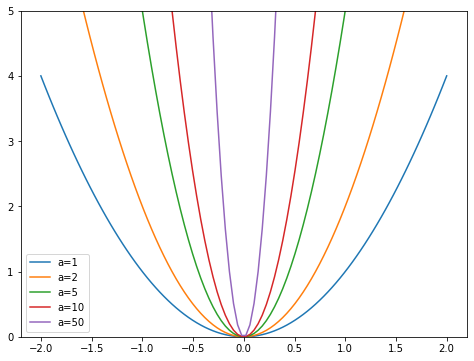

In [37]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Le fait d'empêcher les poids de croitre à un niveau trop élevé va entraver l'entraînement du modèle, mais ça le conduira à un état où il aura une meilleure capacité de généralisation. 

Pour revenir un peu à la théorie, le weight decay (ou simplement wd) est un paramètre qui contrôle la somme des carrés que nous ajoutons à notre fonction de coût (en supposant que params est un tenseur de tous les paramètres) :

```
   loss_with_wd = loss + wd * (params**2).sum()
```

Dans la pratique cependant, il serait très inefficace (et peut-être numériquement instable) de calculer cette grosse somme et de l'ajouter à la fonction de coût. Si vous vous souvenez un peu des mathématiques de lycée, vous vous rappellerez peut-être que la dérivée de p**2 par rapport à p est 2*p, donc ajouter cette grosse somme à notre perte est exactement la même chose que faire :

```
   weight.grad += wd * 2 * weight
```

En pratique, puisque wd est un paramètre que nous choisissons, nous pouvons le rendre deux fois plus grand, de sorte que nous n'avons même pas besoin du *2 dans l'équation ci-dessus. 

Pour utiliser une régularisation L2 ou weight decay dans fastai, il suffit de passer wd dans votre appel à fit() :

In [38]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.963906,0.937282,00:14
1,0.842843,0.852183,00:15
2,0.739652,0.812729,00:14
3,0.599976,0.801394,00:14
4,0.493952,0.802602,00:13


### Créer notre propre module Embedding

nn.Parameter

In [39]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [40]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

nn.Module contenant nn.Parameter

In [41]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.1308],
        [-0.2367],
        [ 0.7793]], requires_grad=True)]

In [42]:
type(t.a.weight)

torch.nn.parameter.Parameter

Remplacer Embedding : création des paramètres et fonction forward

In [44]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [45]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [46]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953978,0.916520,00:14
1,0.828015,0.839050,00:14
2,0.731657,0.808846,00:14
3,0.581206,0.799103,00:15
4,0.481593,0.799320,00:15


## Interpréter les embeddings et les biais (caractéristiques latentes)

In [47]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Crow: City of Angels, The (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Body Parts (1991)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)']

In [48]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Star Wars (1977)']

Il n'est pas si facile d'interpréter directement les matrices d'embeddings. Il y a tout simplement trop de caractéristiques à considérer pour un humain. Mais il existe une technique qui permet d'extraire les directions sous-jacentes les plus importantes dans une telle matrice, appelée **analyse en composantes principales** (**PCA**). 

Nous n'entrerons pas dans le détail de cette technique dans ce livre, mais si vous êtes intéressé, nous vous suggérons de consulter le cours de fast.ai, Computational Linear Algebra for Coders.

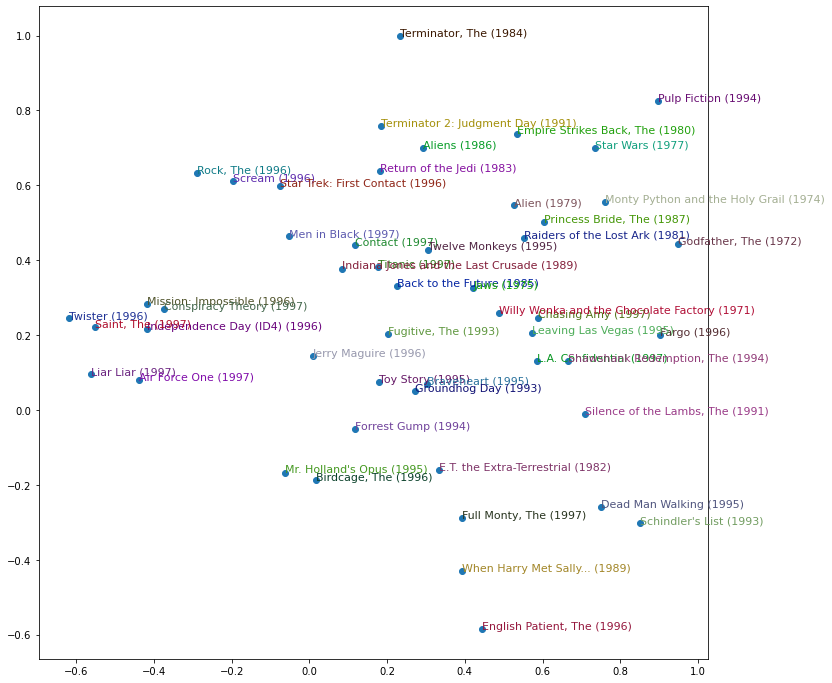

In [49]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()

idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Nous pouvons voir ici que le modèle semble avoir découvert un concept de films classiques par opposition aux films de la culture pop !

Jérémy : "Peu importe le nombre de modèles que j'entraine, je ne cesse de m'émouvoir et de m'étonner de la façon dont ces groupes de nombres initialisés au hasard, entrainés avec une mécanique aussi simple, ont réussi à découvrir des choses sur mes données par eux-mêmes. Cela ressemble presque à de la triche, que je puisse créer un code qui fait des choses utiles, sans jamais lui dire comment faire ces choses !"

### Utiliser fastai.collab

In [50]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [51]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.953041,0.916701,00:14
1,0.836592,0.852352,00:13
2,0.736278,0.814857,00:13
3,0.589610,0.800268,00:13
4,0.467725,0.800845,00:13


In [52]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1641, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1641, 1)
)

In [53]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Silence of the Lambs, The (1991)']

### Embedding distance

Sur une carte bidimensionnelle, nous pouvons calculer la distance entre deux points en utilisant la formule de Pythagore : $\sqrt{x^{2}+y^{2}}$ (en supposant que X et Y sont les distances entre les coordonnées de chaque axe). 

Pour un embedding à 50 dimensions, nous pouvons faire exactement la même chose, sauf que nous additionnons les carrés des 50 distances entre les coordonnées.

Si deux films étaient presque identiques, alors leurs vecteurs d'embedding devraient également être presque identiques, car les utilisateurs qui les aimeraient seraient presque exactement les mêmes. Il y a une idée plus générale ici : la similarité des films peut être définie par la similarité des utilisateurs qui aiment ces films. 

Et cela signifie directement que la distance entre les vecteurs d'embedding de deux films peut définir cette similarité. Nous pouvons utiliser cela pour trouver le film le plus similaire au Silence des agneaux :

In [54]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Right Stuff, The (1983)'

## Comment initialiser un système de recommandation ?

Le plus grand défi que pose l'utilisation de modèles de filtrage collaboratifs dans la pratique est le problème du bootstrapping. La version la plus extrême de ce problème est lorsque vous n'avez pas d'utilisateurs, et donc pas d'historique dont vous pouvez tirer des enseignements. Quel produit recommandez-vous à votre tout premier utilisateur ?

Mais même si vous êtes une entreprise bien établie avec un long historique de transactions d'utilisateurs, vous devez toujours vous poser la question suivante : que faites-vous lorsqu'un nouvel utilisateur s'inscrit ? Et en effet, que faites-vous lorsque vous ajoutez un nouveau produit à votre portefeuille ? Il n'y a pas de solution magique à ce problème, et les solutions que nous proposons ne sont en fait que des variantes de la formule qui font appel à votre bon sens. Vous pouvez initialiser vos nouveaux utilisateurs de telle sorte qu'ils aient la moyenne de tous les vecteurs d'intégration de vos autres utilisateurs - bien que cela pose le problème que cette combinaison particulière de caractéristiques latentrs peut ne pas être du tout commune (par exemple, la moyenne du facteur science-fiction peut être élevée, et la moyenne du facteur action peut être faible, mais il n'est pas si commun de trouver des gens qui aiment la science-fiction sans action). Le mieux serait probablement de choisir un utilisateur particulier pour représenter le goût moyen.

Mieux encore, il est préférable d'utiliser un modèle tabulaire basé sur les métadonnées de l'utilisateur pour construire votre vecteur d'intégration initial. Lorsqu'un utilisateur s'inscrit, réfléchissez aux questions que vous pourriez lui poser et qui pourraient vous aider à comprendre ses goûts. Vous pouvez ensuite créer un modèle dans lequel la variable dépendante est le vecteur d'intégration de l'utilisateur, et les variables indépendantes sont les résultats des questions que vous lui posez, ainsi que les métadonnées de son inscription. Nous apprendrons dans la section suivante comment créer ce genre de modèles tabulaires. Vous avez peut-être remarqué que lorsque vous vous inscrivez à des services tels que Pandora et Netflix, ils ont tendance à vous poser quelques questions sur les genres de films ou de musique que vous aimez ; c'est ainsi qu'ils arrivent à vos premières recommandations de filtrage collaboratif.

Une chose à laquelle il faut faire attention, c'est qu'un petit nombre d'utilisateurs extrêmement enthousiastes peuvent finir par établir efficacement les recommandations pour l'ensemble de votre base d'utilisateurs. C'est un problème très courant, par exemple, dans les systèmes de recommandation de films. Les personnes qui regardent des animés ont tendance à en regarder beaucoup, et pas beaucoup d'autres, et passent beaucoup de temps à mettre leurs évaluations sur des sites web. En conséquence, beaucoup des meilleures listes de films ont tendance à être fortement surreprésentées dans les dessins animés. Dans ce cas particulier, il peut être assez évident que vous avez un problème de biais de représentation, mais si le biais se produit dans les facteurs latents, alors il peut ne pas être évident du tout.

Un tel problème peut modifier toute la composition de votre base d'utilisateurs et le comportement de votre système. Cela est particulièrement vrai en raison des boucles de rétroaction positive. Si un petit nombre de vos utilisateurs a tendance à déterminer l'orientation de votre système de recommandation, ils finiront naturellement par attirer davantage de personnes comme eux dans votre système. Et cela va, bien sûr, amplifier le biais de représentation initial. C'est une tendance naturelle à être amplifiée de manière exponentielle. Vous avez peut-être vu des exemples de dirigeants d'entreprises qui se sont étonnés de la détérioration rapide de leurs plateformes en ligne, de telle sorte qu'ils expriment des valeurs qui sont en contradiction avec celles des fondateurs. En présence de ce genre de boucles de rétroaction, il est facile de voir comment une telle divergence peut se produire à la fois rapidement et de manière cachée jusqu'à ce qu'il soit trop tard.

Dans un système auto-renforçant comme celui-ci, nous devrions probablement nous attendre à ce que ce type de boucles de rétroaction soit la norme, et non l'exception. Par conséquent, vous devez partir du principe que vous les verrez, vous y préparer et déterminer dès le départ comment vous allez traiter ces questions. Essayez de réfléchir à toutes les façons dont les boucles de rétroaction peuvent être représentées dans votre système, et à la façon dont vous pourriez les identifier dans vos données. En fin de compte, cela revient à notre conseil initial sur la manière d'éviter les catastrophes lors du déploiement de tout type de système d'apprentissage automatique. Il s'agit de s'assurer qu'il y a des humains dans la boucle, qu'il y a un suivi attentif et un déploiement progressif et réfléchi.

Notre modèle de produit scalairre fonctionne assez bien et il est à la base de nombreux systèmes de recommandation réussis dans le monde réel. Cette approche du filtrage collaboratif est connue sous le nom de factorisation matricielle probabiliste (PMF). Une autre approche, qui fonctionne généralement aussi bien avec les mêmes données, est le deep learning.

## Deep learning for collaborative filtering

Pour transformer notre architecture en un modèle d'apprentissage profond, la première étape consiste à prendre les embeddings des utilisateurs et des films et à concaténer ces activations ensemble. Cela nous donne une matrice que nous pouvons ensuite passer à travers les couches linéaires et les non-linéarités de la manière habituelle.

Comme nous concaténerons les matrices d'embeddings plutôt que de prendre leur produit scalaire, cela signifie que les deux matrices d'embeddings peuvent avoir des tailles différentes (c'est-à-dire des nombres différents de caractéristiques latentes). 

fastai dispose d'une fonction **get_emb_sz** qui renvoie les tailles recommandées pour les matrices d'intégration de vos données, sur la base d'une heuristique qui, selon fast.ai, tend à bien fonctionner en pratique :

In [56]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1641, 101)]

In [57]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [58]:
model = CollabNN(*embs)

In [59]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.959584,0.930754,00:15
1,0.888677,0.872379,00:14
2,0.874682,0.858566,00:14
3,0.765416,0.850942,00:14
4,0.776806,0.850416,00:15


Bien que les résultats de EmbeddingNN soient un peu moins bons que l'approche par produit scalaire (ce qui montre la puissance de bien choisir une architecture adaptée à un domaine), elle nous permet de faire quelque chose de très important : nous pouvons maintenant intégrer directement d'autres informations sur les utilisateurs et les films, par exemple la durée et d'autres informations qui peuvent être pertinentes pour la recommandation.

In [61]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.985952,0.971263,00:17
1,0.938094,0.902394,00:16
2,0.915141,0.866807,00:17
3,0.842738,0.850814,00:17
4,0.784295,0.849292,00:17


In [62]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1641, 101)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(175, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=175, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

### Note : kwargs et delegates

EmbeddingNN inclut \**kwargs comme paramètre à __init__. En python, \**kwargs dans un paramètre comme signifie "mettre tout argument nommé supplémentaire dans un dictionnaire appelé kwargs". Et \**kwargs dans une liste d'arguments signifie "insérer toutes les paires clé/valeur dans le dictionnaire kwargs en tant qu'arguments nommés ici". 

Cette approche est utilisée dans de nombreuses bibliothèques populaires, telles que matplotlib, dans laquelle la fonction principale de tracé a simplement la signature (*args, \**kwargs). La documentation indique "Les kwargs sont des propriétés de Line2D" et énumère ensuite ces propriétés.

Nous utilisons \**kwargs dans EmbeddingNN pour éviter d'avoir à écrire tous les arguments de TabularModel une seconde fois, et pour les garder synchronisés. Cependant, cela rend notre API assez difficile à utiliser, car maintenant Jupyter Notebook ne sait pas quels paramètres sont disponibles, donc des choses comme la complétion des noms de paramètres ne fonctionneront pas.

Fastai résout ce problème en fournissant un décorateur spécial @delegates, qui modifie automatiquement la signature de la classe ou de la fonction (EmbeddingNN dans ce cas) pour insérer tous les arguments nommés dans la signature